In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
OUT_DIM=6

In [4]:
path = Path("./activations")

In [ ]:
img_files = get_files(path/"img"); img_files

In [ ]:
text_files = get_files(path/"text"); text_files

In [ ]:
text_set = set([t.with_suffix("").name for t in text_files])

In [ ]:
img_set = set([t.with_suffix("").name for t in img_files])

In [ ]:
len(text_set), len(img_set)

In [ ]:
img_and_text = text_set.intersection(text_set, img_set); len(img_and_text)

In [ ]:
just_img = img_set - text_set; len(just_img)

In [ ]:
just_text = text_set - img_set; len(just_text)

In [ ]:
train_csv = pd.read_csv("./data/train_fusion.csv")
val_csv = pd.read_csv("./data/val_fusion.csv")
test_csv = pd.read_csv("./data/test_fusion.csv")

In [ ]:
train_csv["is_valid"] = False
val_csv["is_valid"] = True
data = pd.concat([train_csv, val_csv])

In [ ]:
data["has_text"] = True

In [ ]:
data["has_image"]= ~(data["file_name"].str.slice(stop=-4) + "_" + data["pages"].astype(str)).isin(just_text)

In [ ]:
data.head(1)

In [ ]:
just_imgs = [x for x in img_files if x.with_suffix("").name in just_img]; len(just_imgs), just_imgs[:3]

In [ ]:
just_imgs[0].with_suffix("").as_posix()

In [ ]:
just_imgs_dics = []
for p in tqdm(just_imgs):
    parts = p.parts
    if parts[2] == "test":
        continue
    dic = {}
    dic["process_id"] = re.search(r"[^_]*_\d+",parts[4])[0]
    dic["file_name"] = parts[4][:-2] + "pdf"
    dic["document_type"] = parts[3]
    dic["pages"] = re.search(r"(?<=_)\d+(?=\.pt)", parts[4])[0]
    dic["is_valid"] = parts[2] == "val"
    dic["has_text"] = False
    dic["has_image"] = True
    dic["activation_path"] = p.with_suffix("").as_posix()
    just_imgs_dics.append(dic)

In [ ]:
just_imgs_df = pd.DataFrame(just_imgs_dics, columns = data.columns); just_imgs_df.head()

In [ ]:
data = pd.concat([data, just_imgs_df])

In [ ]:
data.head(1)

In [ ]:
data.tail()

In [ ]:
img_files

In [ ]:
class GetActs(Transform):
    def encodes(self, x):        
        img_file = text_file = None
        
        if x["has_text"]:
            text_file = Path(x["activation_path"] + ".npy")
            if x["has_image"]:
                img_file = Path(text_file.as_posix().replace("text", "img").replace("npy", "pt"))
        else:
            img_file = Path(x["activation_path"] + ".pt")
        
        if img_file is None:
            img_act = torch.zeros((4096))
        else:
            img_act = torch.load(img_file)
                            
        if text_file is None:
            text_act = torch.zeros((3840))
            text_none = True
        else:
            text_act = tensor(np.load(text_file))
        
        img_none = img_file == None
        text_none = text_file == None
                            
        return (img_act, text_act, img_none, text_none)

In [ ]:
tfms = [[GetActs()], [ColReader("document_type"), Categorize()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders()

In [ ]:
dls.train_ds, dls.valid_ds

In [29]:
torch.save(dls, "./data/fusion_dl_v2.pth")

In [ ]:
class ImgTextFusion(Module):
    def __init__(self, head, embs_for_none=True, img_emb_dim=4096, text_emb_dim=3840):
        self.head = head.cuda()
        self.embs_for_none = embs_for_none
        if embs_for_none:
            self.img_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=img_emb_dim).cuda()
            self.text_none_emb = torch.nn.Embedding(num_embeddings=1, embedding_dim=text_emb_dim).cuda()
            self.index= tensor(0).cuda()
    
    def forward(self, x):
        img_act, text_act, img_none, text_none = x
        if self.embs_for_none:
            img_act[img_none] = self.img_none_emb(self.index)
            text_act[text_none] = self.text_none_emb(self.index)
        return self.head(torch.cat([img_act, text_act], axis=-1))

In [ ]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [ ]:
head = create_head(4096 + 3840, OUT_DIM)

In [ ]:
model = ImgTextFusion(head)

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [ ]:
fscore = F1Score(average='macro')

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [37]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 512             4,063,232  True      
________________________________________________________________
ReLU                 64 x 512             0          False     
________________________________________________________________
BatchNorm1d          64 x 512             1,024      True      
________________________________________________________________
Dropout              64 x 512             0          False     
________________________________________________________________
Linear               64 x 6               3,072      True      
__________________________

In [38]:
learn.validate()

(#3) [1.8902353048324585,0.06514403969049454,0.03851316032419575]

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.033113110810518265)

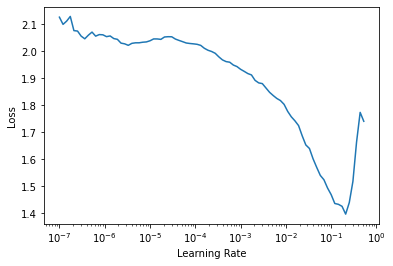

In [39]:
learn.lr_find()

In [40]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.131739,0.348441,0.935274,0.672572,15:44
1,0.291994,5.453568,0.934800,0.637809,14:23
2,0.298876,15.286951,0.887708,0.627845,09:36
3,0.230524,37.713543,0.904766,0.637539,13:00
4,0.182112,14.794328,0.926072,0.673981,09:10
5,0.147666,13.552425,0.916701,0.602307,09:54
6,0.114618,3.131024,0.931472,0.628361,09:22
7,0.092870,2.570963,0.932932,0.720946,13:29
8,0.076512,0.749836,0.938230,0.744888,13:15
9,0.068449,0.728586,0.936241,0.735874,10:21


Better model found at epoch 0 with f1_score value: 0.6725719070133347.


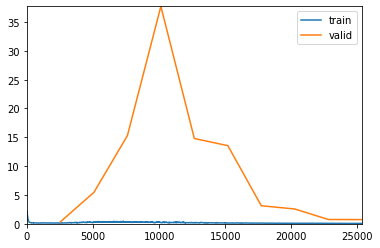

Better model found at epoch 4 with f1_score value: 0.6739808206480098.
Better model found at epoch 7 with f1_score value: 0.7209462957822724.
Better model found at epoch 8 with f1_score value: 0.7448881977719647.


In [41]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [42]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [43]:
model = ImgTextFusion(head)

In [44]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [45]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.05754399299621582)

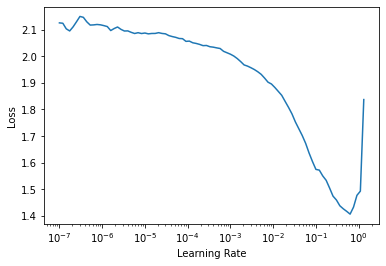

In [46]:
learn.lr_find()

In [47]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.111767,0.318527,0.932802,0.711490,12:27
1,0.174509,0.365068,0.921889,0.648039,09:10
2,0.160119,0.401786,0.940591,0.686464,12:06
3,0.128145,0.407585,0.934484,0.745064,09:01
4,0.138169,0.363576,0.928935,0.725094,09:20
5,0.116382,0.333210,0.940889,0.729689,08:38
6,0.104146,0.330326,0.935469,0.725900,09:08
7,0.084555,0.340151,0.940229,0.755843,09:04
8,0.072960,0.335384,0.937431,0.752836,09:23
9,0.061528,0.340817,0.937877,0.757009,09:15


Better model found at epoch 0 with f1_score value: 0.7114898080586037.


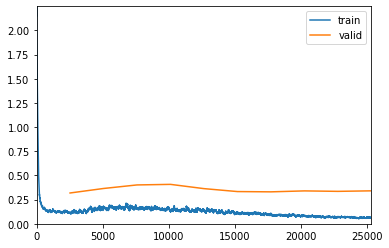

Better model found at epoch 3 with f1_score value: 0.7450638978996572.
Better model found at epoch 7 with f1_score value: 0.7558425334721441.
Better model found at epoch 9 with f1_score value: 0.7570090762836553.


In [48]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [49]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [50]:
model = ImgTextFusion(head, embs_for_none=False)

In [51]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [52]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 128             1,015,808  True      
________________________________________________________________
ReLU                 64 x 128             0          False     
________________________________________________________________
BatchNorm1d          64 x 128             256        True      
________________________________________________________________
Dropout              64 x 128             0          False     
________________________________________________________________
Linear               64 x 6               768        True      
__________________________

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.04786301031708717)

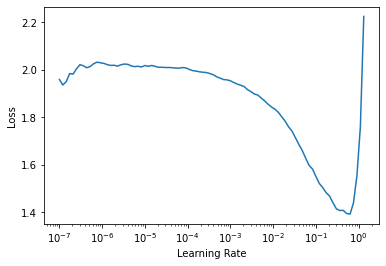

In [53]:
learn.lr_find()

In [54]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_zeros_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.124862,0.339112,0.936074,0.729532,08:46
1,0.163470,111.995667,0.929009,0.675195,09:15
2,0.150095,38.121208,0.928135,0.672877,09:15
3,0.134530,46.916451,0.933322,0.617685,09:04
4,0.133082,14.932535,0.931361,0.675701,08:53
5,0.133936,2.765510,0.934326,0.722971,10:29
6,0.097465,0.981617,0.935246,0.706344,13:34
7,0.093423,12.383939,0.927782,0.721338,09:23
8,0.078366,46.710049,0.935999,0.724759,08:27
9,0.068153,123.399246,0.935906,0.698485,08:13


Better model found at epoch 0 with f1_score value: 0.7295321271489343.


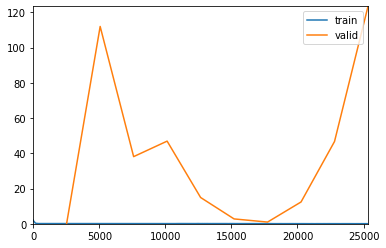

In [55]:
learn.fit_one_cycle(10, lr_max=5e-2)

In [56]:
head = create_head(4096 + 3840, OUT_DIM)

In [57]:
model = ImgTextFusion(head, embs_for_none=False)

In [58]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [59]:
learn.summary()

ImgTextFusion (Input shape: ["['64 x 4096', '64 x 3840', '64', '64']"])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 7936            15,872     True      
________________________________________________________________
Dropout              64 x 7936            0          False     
________________________________________________________________
Linear               64 x 512             4,063,232  True      
________________________________________________________________
ReLU                 64 x 512             0          False     
________________________________________________________________
BatchNorm1d          64 x 512             1,024      True      
________________________________________________________________
Dropout              64 x 512             0          False     
________________________________________________________________
Linear               64 x 6               3,072      True      
__________________________

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.05754399299621582)

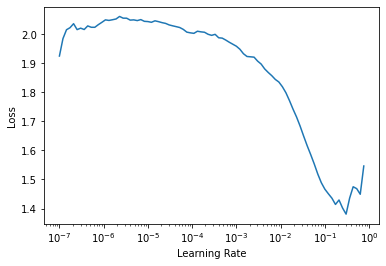

In [60]:
learn.lr_find()

In [61]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_zeros'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.136105,0.382641,0.935776,0.670141,08:25
1,0.169690,10.462007,0.922716,0.680197,08:18
2,0.125932,42.488251,0.932430,0.610578,08:06
3,0.135259,64.416458,0.927633,0.636847,08:09
4,0.137057,51.589722,0.924882,0.604745,07:59
5,0.103535,30.852674,0.931361,0.625138,07:43
6,0.089901,29.167452,0.931519,0.669741,07:50
7,0.084975,84.418800,0.930812,0.662301,07:49
8,0.064950,202.954239,0.931844,0.649173,07:42


Better model found at epoch 1 with f1_score value: 0.6801970953120894.


In [ ]:
head = create_head(4096 + 3840, OUT_DIM, lin_ftrs=[128])

In [ ]:
model = ImgTextFusion(head)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy, fscore])

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_fusion_128_moreEpochs'),
                                       ShowGraphCallback()])

In [67]:
learn.fit_one_cycle(20, lr_max=5e-2)

Better model found at epoch 1 with f1_score value: 0.73676453092147.
Better model found at epoch 9 with f1_score value: 0.7467886756819134.
Better model found at epoch 13 with f1_score value: 0.7492037170891946.
Better model found at epoch 14 with f1_score value: 0.7495923055976403.
Better model found at epoch 16 with f1_score value: 0.7565404539962944.
Better model found at epoch 18 with f1_score value: 0.7630455710960495.


In [ ]:
from utils import evaluate

In [ ]:
learn.load("best_fusion_128_moreEpochs")

In [70]:
from sklearn.metrics import classification_report

preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8926    0.7531    0.8169       320
agravo_em_recurso_extraordinario     0.5754    0.5193    0.5459      2798
     despacho_de_admissibilidade     0.7925    0.6667    0.7241       189
                          outros     0.9617    0.9730    0.9673     95602
                   peticao_do_RE     0.7473    0.7013    0.7236      6987
                        sentenca     0.9004    0.7204    0.8004      1681

                        accuracy                         0.9384    107577
                       macro avg     0.8116    0.7223    0.7630    107577
                    weighted avg     0.9363    0.9384    0.9370    107577



In [ ]:
test_csv["has_text"] = True

In [ ]:
test_csv["has_image"]= ~(test_csv["file_name"].str.slice(stop=-4) + "_" + test_csv["pages"].astype(str)).isin(just_text)

In [ ]:
just_imgs_dics_test = []
for p in tqdm(just_imgs):
    parts = p.parts
    if parts[2] != "test":
        continue
    dic = {}
    dic["process_id"] = re.search(r"[^_]*_\d+",parts[4])[0]
    dic["file_name"] = parts[4][:-2] + "pdf"
    dic["document_type"] = parts[3]
    dic["pages"] = re.search(r"(?<=_)\d+(?=\.pt)", parts[4])[0]
    dic["has_text"] = False
    dic["has_image"] = True
    dic["activation_path"] = p.with_suffix("").as_posix()
    just_imgs_dics_test.append(dic)

In [ ]:
just_imgs_df_test = pd.DataFrame(just_imgs_dics_test, columns = data.columns); just_imgs_df_test.head()

In [ ]:
test_data = pd.concat([test_csv, just_imgs_df_test])

In [ ]:
test_data.tail()

In [77]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [78]:
img_test_data = test_data[test_data["has_image"]==True].drop_duplicates("activation_path"); len(img_test_data)

98577

In [79]:
img_test_dl = dls.test_dl(img_test_data, with_labels=True)

In [80]:
text_test_data = test_data[test_data["has_text"]==True]; len(text_test_data)

95526

In [81]:
text_test_dl = dls.test_dl(text_test_data, with_labels=True)

In [82]:
preds, targets = learn.get_preds(dl=test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8993    0.8711    0.8850       287
agravo_em_recurso_extraordinario     0.6224    0.5190    0.5660      2655
     despacho_de_admissibilidade     0.7450    0.5578    0.6379       199
                          outros     0.9655    0.9752    0.9703     92533
                   peticao_do_RE     0.7628    0.7386    0.7505      6386
                        sentenca     0.8866    0.7492    0.8121      1503

                        accuracy                         0.9446    103563
                       macro avg     0.8136    0.7352    0.7703    103563
                    weighted avg     0.9424    0.9446    0.9432    103563



In [83]:
preds, targets = learn.get_preds(dl=img_test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.9058    0.8772    0.8913       285
agravo_em_recurso_extraordinario     0.6322    0.5278    0.5753      2537
     despacho_de_admissibilidade     0.7551    0.5606    0.6435       198
                          outros     0.9666    0.9753    0.9709     87902
                   peticao_do_RE     0.7706    0.7593    0.7649      6177
                        sentenca     0.8957    0.7612    0.8230      1478

                        accuracy                         0.9459     98577
                       macro avg     0.8210    0.7436    0.7781     98577
                    weighted avg     0.9441    0.9459    0.9447     98577



In [84]:
preds, targets = learn.get_preds(dl=text_test_dl)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8993    0.9158    0.9074       273
agravo_em_recurso_extraordinario     0.6383    0.5301    0.5792      1841
     despacho_de_admissibilidade     0.7450    0.5606    0.6398       198
                          outros     0.9683    0.9766    0.9724     85408
                   peticao_do_RE     0.7653    0.7444    0.7547      6331
                        sentenca     0.8866    0.7634    0.8204      1475

                        accuracy                         0.9483     95526
                       macro avg     0.8171    0.7485    0.7790     95526
                    weighted avg     0.9465    0.9483    0.9472     95526



In [85]:
torch.save(test_dl, "./data/test_dl_fusion.pth")

In [86]:
torch.save(img_test_dl, "./data/test_dl_fusion_img.pth")

In [ ]:
torch.save(text_test_dl, "./data/test_dl_fusion_text.pth")